## Section 2: 

Récupération de la donnée: 


``` bash
    curl -X GET https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/refs/heads/main/causal-inference-in-python/data/cross_sell_email.csv > cross_sell_email.csv
```

source: https://github.com/matheusfacure/causal-inference-in-python-code/tree/main/causal-inference-in-python/data


In [4]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/cross_sell_email.csv")
data

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0
...,...,...,...,...
318,0,long,18,0
319,1,no_email,16,0
320,0,no_email,15,0
321,1,no_email,16,0


In [14]:
mean = data.groupby("cross_sell_email").mean()
mean.conversion.str.strip()

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


Comme nous pouvons le voir il y a deux modalités (le groupe neutre ne comptant pas comme ne modalité).

Ici nous obtenons les scores de: 

- 4 % pour le groupe controle, soit $ E[Y|T=0] $, 
- 5 % pour l'envoie d'email long, soit $ E[Y|T=1] $,
- 12 % pour l'envoie d'email court, soit $ E[Y|T=2] $


Egalement côté, similarité des groupes, la randomisation a mal été faite coté gender où les différences entre H/F sont plus forte dans short avec 63% d'homme (car homme = 1 dans la colonne gender), hors dans les autres nous avons env. 55% d'homme ce qui équilibre davantage les groupes. 

Coté age, les groupes sembles similaires ce qui ne soulève pas de problème à première vue.


In [19]:
mean["ATE"] = mean.conversion - mean.loc["no_email", "conversion"]
print(mean[["conversion", "ATE"]].to_string(formatters={"ATE": "{:,.2f}".format, "conversion": "{:,.2f}".format}))

                 conversion  ATE
cross_sell_email                
long                   0.06 0.01
no_email               0.04 0.00
short                  0.12 0.08


L'ATE est de:
 
- 1 % pour l'envoie d'email long, soit $ E[Y|T=1] - E[Y|T=0] $,
- 8 % pour l'envoie d'email court, soit $ E[Y|T=2] - E[Y|T=0] $

=> Page 35

In [20]:
X = ["gender", "age"]

mu = data.groupby("cross_sell_email")[X].mean()
var = data.groupby("cross_sell_email")[X].var()

norm_diff = ((mu - mu.loc["no_email"])/np.sqrt((var + var.loc["no_email"])/2))
norm_diff

,gender,age
cross_sell_email,,
long,0.015802,0.221423
no_email,0.000000,0.000000
short,0.184341,0.087370


Pour vérfier si la différence est forte, il verifier la différence normalisé:

$$ 
    \frac{ \hat{\mu}_{tr} - \hat{\mu}_{co} } { \sqrt{ (\hat{\sigma}_{tr}^{2} - \hat{\sigma}_{co}^{2})/2 } }
$$

Où:
- tr = traitement donc t=i
- co = controle donc t=0


Ici on remarque que les modalités conjointes short\gender ont normale différentielle forte qui montre un ecart fort entre les deux autres groupe (t=0 et t=long).
C'est aussi le cas pour le groupe long\age.

=> page 36

**Conclusion:**   
Bref, ces dernières ont servis pour montrer le "randomized controlled trials" (RCT), s'il est mal fait nos résultats montre une différence mais qui peut etre induit par un biais et non le traitement. En locurence ici, les hommes peuvent avoir plus tendance à consommer que les femmes ce qui fait que le taux de réussite peut etre plus important dans ce dernier (email court) que dans les autres modalités.


Parfois pour des raisons éthiques, budgetaire ou autre, le RCT n'est pas possible ainsi nous passons à l'échantillon observé qui peut contenir des biais dans nos données.

---

## Partie 2: Que faire quand on a pas de randomisation

``` bash
    curl -X GET https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/refs/heads/main/causal-inference-in-python/data/enem_scores.csv > ./data/enem_scores.csv
```

### **Les équations dangeureuses**

Il existe deux types d'équations dangueureuse: 
1. Si on connait ces équations, elles sont dangeureuses (la masse critique pour faire un explosif),
2. Si on connait mal/pas ces equations, cela est dangeureux (exemple équation de Moivre: $ SE =  \frac{\sigma}{\sqrt{n}} $) 


**Verifions pourquoi cette équation est dangeureuse ?**

In [24]:
df = pd.read_csv("./data/enem_scores.csv")

df.sort_values("avg_score", ascending=False).head(10) 

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


/tmp/ipykernel_69710/3405166342.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x=[df_other, df_max], labels=["df_other", "df_max"])


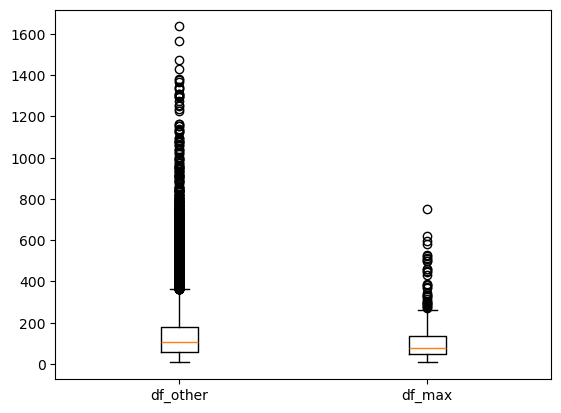

In [66]:
import matplotlib.pyplot as plt

df["cat"] = pd.qcut( df["avg_score"], q=100)
df["cat"].cat.categories.min()

df_max = df[df["cat"] == df["cat"].cat.categories.max()].number_of_students
df_other = df[df["cat"] != df["cat"].cat.categories.max()].number_of_students

plt.boxplot(x=[df_other, df_max], labels=["df_other", "df_max"])
plt.show()

Si on a analyse seulement, les ecoles avec les meilleurs réussites on peut voir que moins il y a d'élèves, plus les élèves sont doués. On a par exemple ici le 1% des ecoles les mieux classés en terme d'examens contre les 99% autre restants.

Pourquoi il y a une erreurs dans ce raisonnement. En effet, pourquoi ne pas verifier que les 1 % les moins bons peuvent etre différents. 

Comme vous pouvez le voir, le résultat est directement orienté sur l'hypothèse populaire: "Moins il y a d'élève mieux sont les résultats", hors cela peut etre un biais de confirmation qui peut influencer notre étude.

/tmp/ipykernel_69710/2123125345.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x=[df_min, df_other, df_max], labels=["df_min", "df_other", "df_max"])


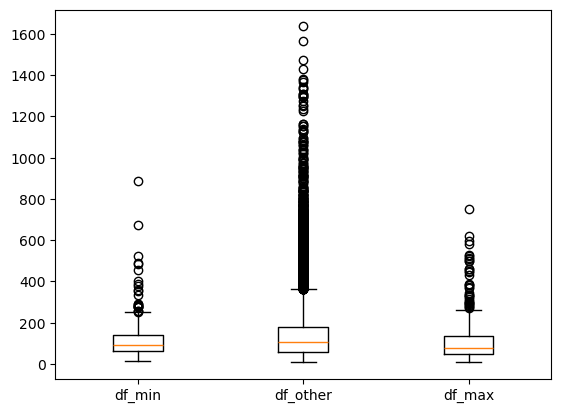

In [58]:
df_min = df[df["cat"] == df["cat"].cat.categories.min()].number_of_students

plt.boxplot(x=[df_min, df_other, df_max], labels=["df_min", "df_other", "df_max"])
plt.show()

Comme vous pouvez le voir on tombe sur un tous autre résultat. Les petits établissements peuvent avoir aussi des très mauvais résultat. 

**Alors pourquoi ?**

C'est l'effet de l'aléatoire, plus il y a l'élèves plus on tends à une moyenne, au contraire les petits établissements sont sujets à des décalages bénéfiques ou non, donc il peut y avoir une surpopulation de bon ou de mauvais élèves à comparer des autres grands échantillons.

Si on reprend la formule de Moivre qui estime l'incertitude: $ SE =  \frac{\sigma}{\sqrt{n}} $

On peux voir clairement que plus il y a d'élèves dans un établissement, plus il converge vers un point (la moyenne). 

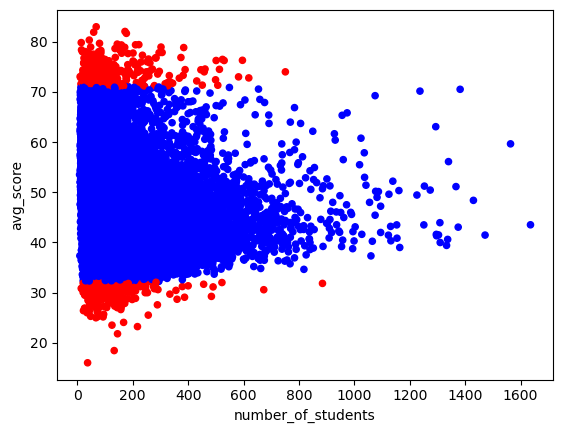

In [65]:
idx_is_not_99 = df["cat"].isin([df["cat"].cat.categories.min(), df["cat"].cat.categories.max()])
df.plot.scatter(x="number_of_students", y="avg_score", c=["r" if s else "b" for s in idx_is_not_99.to_list()])
plt.show()

## Reprise de l'étude de l'A/B testing

In [69]:
get_data = lambda name: data.query(f"cross_sell_email=='{name}'")["conversion"]

short_email = get_data("short")
long_email = get_data("long")
no_email = get_data("no_email")
email = data.query(f"cross_sell_email!='no_email'")["conversion"]


size_group = data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64

In [75]:
def se(y:pd.Series):
    return y.std() / np.sqrt(len(y))

print("Erreur standart du groupe email long:", round(se(long_email), 2), "et version pandas:", round(long_email.sem(), 2))
print("Erreur standart du groupe email court:", round(se(short_email), 2), "et version pandas:", round(short_email.sem(), 2))

Erreur standart du groupe email long: 0.02 et version pandas: 0.02
Erreur standart du groupe email court: 0.03 et version pandas: 0.03


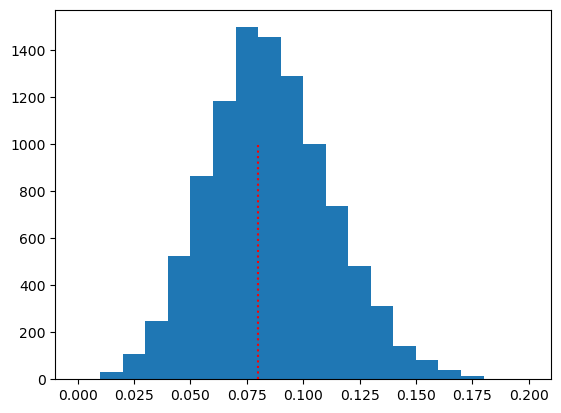

In [133]:
get_bernouilli = lambda: np.random.binomial(1, 0.08, 100)

np.random.seed(42)

exps = [get_bernouilli().mean() for _ in range(10000)]

plt.hist(exps, bins=20)
plt.vlines(0.08, ymax=1000, ymin=0, colors="r", linestyles='dotted')

Comment on peut le voir, nous avons l'utilisation du théorème centrale limite. 

Le but étant de trouver le moyenne des moyennes. Selon le livre, la moyenne des données est toujours normalement distribué. 

In [152]:
exp_se = short_email.sem()
exp_mu = short_email.mean()
for nb_sigma in [1, 2]:
    print("\nPour ",nb_sigma, " Sigma on a:")

    ci = (round(exp_mu - nb_sigma* exp_se, 2), round(exp_mu + nb_sigma* exp_se, 2))

    print("L'intervale de confience du mu de notre expérience est:", ci) 


Pour  1  Sigma on a:
L'intervale de confience du mu de notre expérience est: (0.09, 0.16)

Pour  2  Sigma on a:
L'intervale de confience du mu de notre expérience est: (0.06, 0.19)


Ou en fonction de alpha, la formule (ppf) récupère l'inverse de la fonction cumulative de la loi normale. 

In [171]:
from scipy import stats

for alpha in [0.99, 0.95, 0.90]:
    interval_sigma = np.abs(stats.norm.ppf((1-alpha)/2))
    print("\nPour un intervale à ",alpha, "% on as", round(interval_sigma, 2))

    ci = (round(exp_mu - interval_sigma* exp_se, 4), round(exp_mu + interval_sigma* exp_se, 4))
    print("L'intervale de confience du mu de notre expérience est:", ci) 


Pour un intervale à  0.99 % on as 2.58
L'intervale de confience du mu de notre expérience est: (0.0469, 0.2031)

Pour un intervale à  0.95 % on as 1.96
L'intervale de confience du mu de notre expérience est: (0.0656, 0.1844)

Pour un intervale à  0.9 % on as 1.64
L'intervale de confience du mu de notre expérience est: (0.0751, 0.1749)
